# Removing seasonal observation bias from an irregular time series

The ICES database contains observation data for Landsort Deep SST from the 19th century on. Can we find out if there is a long-term trend?

Let us first load the data.

In [1]:
setwd("/silod5/radtke/notebooks/stat_timeseries/seasonal_observation_bias/")
icesdata = read.csv("sst_by31.csv",sep=";")
head(icesdata)
plot(icesdata,xlab = "year")

decimalyear temperature
1 1877.566    15.40      
2 1891.680    10.40      
3 1893.505    13.55      
4 1898.284     2.07      
5 1898.713    11.53      
6 1899.418     5.56

Let's try to do a GAMM analysis

Loading required package: nlme
This is mgcv 1.8-28. For overview type 'help("mgcv-package")'.


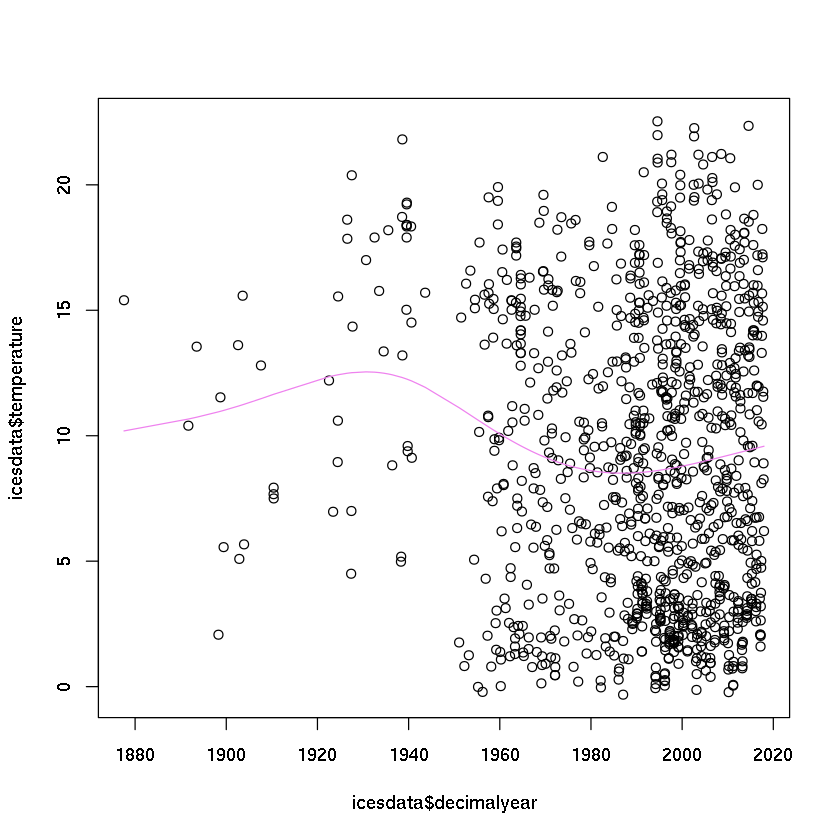

In [2]:
library("mgcv")
x_values = seq(from=1870,to=2020,by=10)
ices_gamm = gamm(temperature ~ s(decimalyear, bs="cr", k = length(x_values)) , data=icesdata, 
                 knots=list(decimalyear=x_values), optimMethod="ML")
plot(icesdata$decimalyear, icesdata$temperature)
lines(icesdata$decimalyear, predict(ices_gamm$gam), col="violet")

That looks weird: Do we really see a cooling here?

These data are irregular and have a pronounced seasonal cycle.

You may find a **seasonal observation bias**: 
Assume you find a long-term trend - is that 
* because it is actually getting warmer, or
* because you measured more often in summer?

Let's add a column **season** to the data frame.

In [3]:
# get the year
icesdata$year = floor(icesdata$decimalyear)
# subtract it from decimalyear to get the season
icesdata$season = icesdata$decimalyear - icesdata$year

head(icesdata)

decimalyear temperature year season   
1 1877.566    15.40       1877 0.5655738
2 1891.680    10.40       1891 0.6803279
3 1893.505    13.55       1893 0.5054645
4 1898.284     2.07       1898 0.2841530
5 1898.713    11.53       1898 0.7131148
6 1899.418     5.56       1899 0.4180328

We can now fit a statistical model like this:
$$ temperature = \beta_0 + s_1(decimalyear) + s_2(season) + \varepsilon $$

which explicitly contains seasonality.

This idea follows this online tutorial:
[ https://www.fromthebottomoftheheap.net/2014/05/09/modelling-seasonal-data-with-gam/ ]

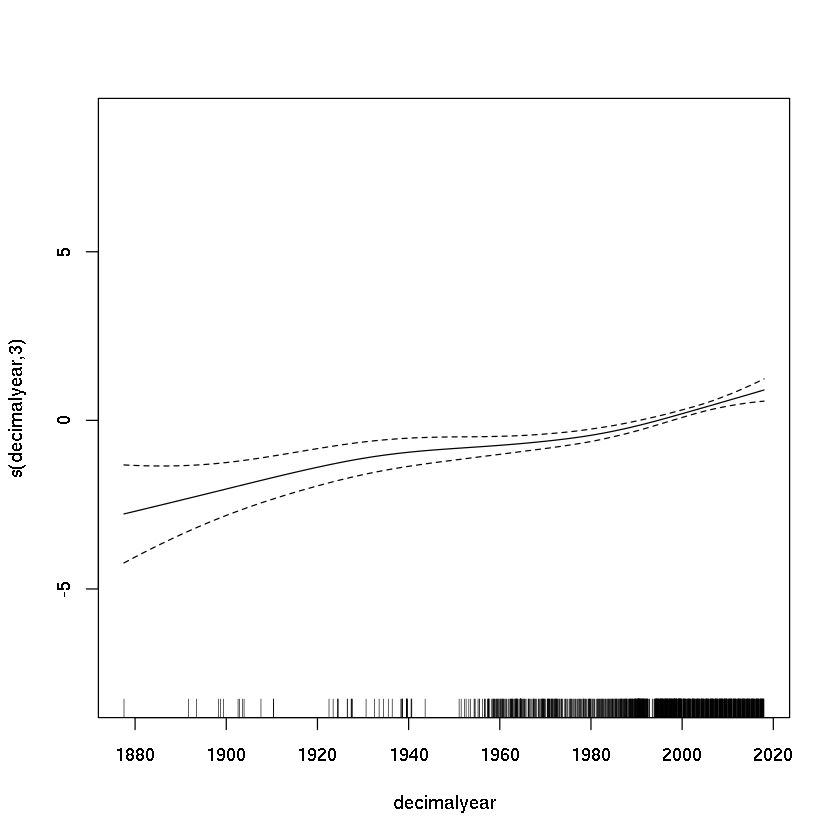

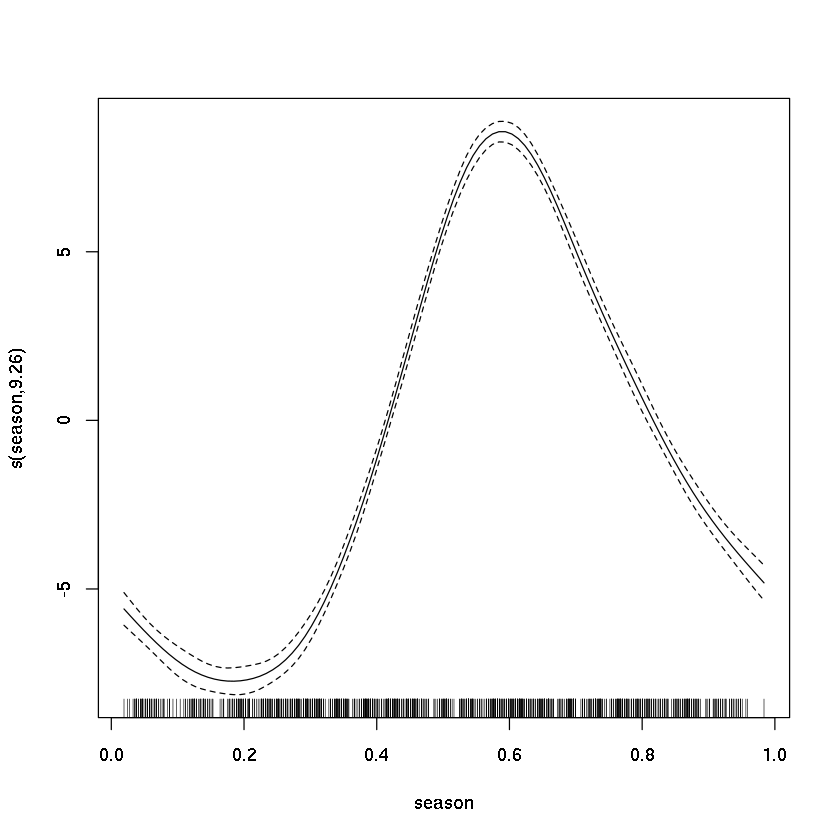

In [4]:
ices_gamm = gamm(temperature ~ s(decimalyear, bs="cr", k = length(x_values)) + s(season, bs="cc",k=12), data=icesdata, 
                 knots=list(decimalyear=x_values, season=c(0,1)), optimMethod="ML", 
                 correlation = corCAR1(form = ~ decimalyear|year))
plot(ices_gamm$gam)

Now we want to plot the temperature trend together with the data. To do so, we have to make a prediction term by term:

In [11]:
ices_gamm$gam$coefficients

(Intercept)  s(decimalyear).1  s(decimalyear).2  s(decimalyear).3 
       9.13389780       -2.68996241       -2.35917644       -1.98727395 
 s(decimalyear).4  s(decimalyear).5  s(decimalyear).6  s(decimalyear).7 
      -1.67579649       -1.36176245       -1.04065407       -0.82306146 
 s(decimalyear).8  s(decimalyear).9 s(decimalyear).10 s(decimalyear).11 
      -0.79009930       -0.19605507        0.02941994        0.03002634 
s(decimalyear).12 s(decimalyear).13 s(decimalyear).14 s(decimalyear).15 
       1.22173680        1.95419596        2.31974460        1.34629030 
      s(season).1       s(season).2       s(season).3       s(season).4 
      -6.38722798       -6.59266734       -4.91834886       -1.34533743 
      s(season).5       s(season).6       s(season).7       s(season).8 
       3.87310540        9.09111237        9.98226675        6.05238059 
      s(season).9      s(season).10 
       2.32899575       -0.79194631

In [9]:
# get the intercept - it is the first of the coefficients
intercept = ices_gamm$gam$coefficients[1]
intercept

# predict the terms one by one
my_prediction = predict(ices_gamm$gam,se.fit=TRUE,type="terms")
summary(my_prediction)
head(my_prediction)

(Intercept) 
   9.133898

       Length Class  Mode   
fit    2150   -none- numeric
se.fit 2150   -none- numeric

$fit
     s(decimalyear)   s(season)
1     -2.7748033154  8.36723477
2     -2.3124894858  5.97598002
3     -2.2520321740  5.98367255
4     -2.0929778982 -6.62264173
5     -2.0786554276  4.41267087
6     -2.0551057920  0.05157127
7     -1.9490123938  8.56824153
8     -1.9399690264 -1.61918492
9     -1.9154107996  8.55256334
10    -1.9051934756 -2.86776638
11    -1.7820216200  8.41983624
12    -1.6911881471 -2.40176591
13    -1.6908326084 -1.73290098
14    -1.6902993462 -0.67876023
15    -1.3179162831  7.49699807
16    -1.2927048808  1.36794189
17    -1.2652507472  1.55888885
18    -1.2639947607  4.78585276
19    -1.2626664557  7.49699807
20    -1.2102950330  7.14017835
21    -1.2095969618  8.13181572
22    -1.1850617332  7.26433618
23    -1.1808792078  5.06189305
24    -1.1885199239 -1.73290098
25    -1.1871618739  1.94227567
26    -1.1117141504  6.60127559
27    -1.0725085223  7.14017835
28    -1.0526910309  7.26433618
29    -1.0338697006  7.14017835
30    -1.0156766981  7.60512939
31    -1.0008316771 -1.03619678
32    -0.9663112100  8.41186641
33    -0.9700779264 -5.43487277
34    -0.9693704749 -3.19214459
35    -0.9655310198  8.21920005
36    -0.9653260656  7.85643880
37    -0.9515038906  8.53429565
38    -0.9524007892  6.59571668
39    -0.9516986048  8.36723477
40    -0.9515428217  8.51204992
41    -0.9510371736  8.37746888
42    -0.9484852764  0.96859959
43    -0.9484468068  0.85718964
44    -0.9516207016  8.45086181
45    -0.9515817587  8.48424748
46    -0.9381970663  7.60512939
47    -0.9371289206  8.27712428
48    -0.9360288172  5.06189305
49    -0.8997156636  8.08819268
50    -0.8246910249 -6.80414815
51    -0.8205808719  7.14017835
52    -0.8107062407  8.41983624
53    -0.8141916471 -7.56539060
54    -0.8052585788 -7.68221731
55    -0.8022229544  7.70754578
56    -0.7931169942  7.60512939
57    -0.7928667084  8.36723477
58    -0.7947175727 -3.34355805
59    -0.7845197731  3.86132719
60    -0.7837865918  8.05860530
61    -0.7867905682 -7.56539060
62    -0.7733025327  6.23053296
63    -0.7711090055 -3.01585138
64    -0.7774575204 -7.51736337
65    -0.7735856991  7.48945132
66    -0.7652264234  7.01105111
67    -0.7658286577  3.09823500
68    -0.7660902365  1.17758290
69    -0.7672914846 -5.85249932
70    -0.7662471080  0.05157127
71    -0.7638091192  6.35577789
72    -0.7649643179  8.05860530
73    -0.7643608598  8.32988940
74    -0.7542293399  7.06709952
75    -0.7594212479 -7.45511455
76    -0.7553326636  7.80409635
77    -0.7526086119 -0.12280353
78    -0.7547141380  8.45696496
79    -0.7524461331 -0.74605112
80    -0.7565666004  0.05157127
81    -0.7449710761  8.55101117
82    -0.7499453171 -6.94319821
83    -0.7478930958 -6.39283110
84    -0.7449433865  8.56222298
85    -0.7423579004 -0.84701170
86    -0.7487428489 -7.68221731
87    -0.7469035871 -1.73290098
88    -0.7447772001  8.51540047
89    -0.7424137207 -0.64420669
90    -0.7351594181  7.49699807
91    -0.7398076785 -6.94319821
92    -0.7385107163 -7.65626333
93    -0.7338721055  6.95425451
94    -0.7320323764 -0.64420669
95    -0.7381432233 -7.32688830
96    -0.7366121682 -1.38775773
97    -0.7344448795  8.48882854
98    -0.7320900264 -0.43798931
99    -0.7248627079  5.98367255
100   -0.7298340681 -6.06124993
101   -0.7272700390 -6.69317842
102   -0.7243319158  8.13181572
103   -0.7211590520 -1.14428257
104   -0.7152681674 -2.23739678
105   -0.7114878785  4.03211553
106   -0.7133222586  8.19925737
107   -0.7109663548  1.98912952
108   -0.7191868467 -5.77070508
109   -0.7167505327 -7.32688830
110   -0.7103517867 -0.22860572
111   -0.7129561656  8.56824153
112   -0.7153894192 -2.88253621
113   -0.7128951120  8.55256334
114   -0.7045523591 -4.85137672
115   -0.7045210861 -4.72675963
116   -0.7002102885  4.54106914
117   -0.7021361815  7.80409635
118   -0.7015374328  8.55256334
119   -0.6986556775 -1.04615819
120   -0.7080683535 -5.71170901
121   -0.7013796992  8.41983624
122   -0.7013481441  8.37746888
123   -0.6990687855  0.30708995
124   -0.7043333896 -3.9259

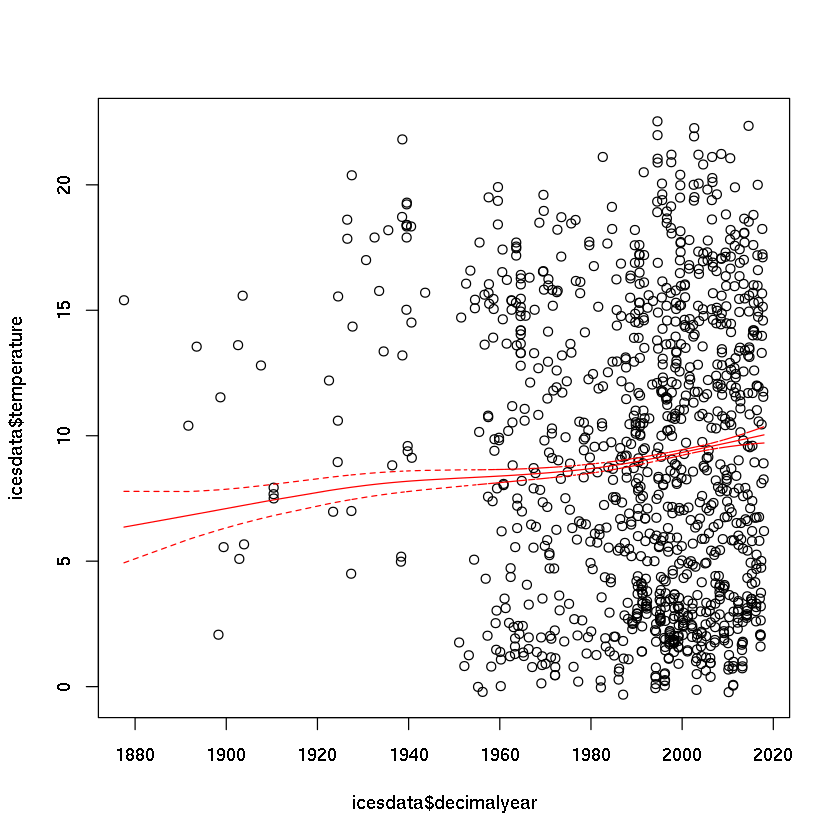

In [6]:
# get the temperature from the first columm
pred_temperature = intercept + my_prediction$fit[,1]

# get minimum and maximum temperature
pred_temperature_min = intercept + my_prediction$fit[,1] - 1.96*my_prediction$se.fit[,1]
pred_temperature_max = intercept + my_prediction$fit[,1] + 1.96*my_prediction$se.fit[,1]

# do the plot
plot(icesdata$decimalyear, icesdata$temperature)
lines(icesdata$decimalyear, pred_temperature, col="red")
lines(icesdata$decimalyear, pred_temperature_min, lty=2, col="red")
lines(icesdata$decimalyear, pred_temperature_max, lty=2, col="red")


Where is the trend significant? We define a function for that:

In [7]:
################################################
## Functions for derivatives of GAM(M) models ##
################################################
Deriv <- function(mod, n = 200, eps = 1e-7, newdata, term) {
    if(inherits(mod, "gamm"))
        mod <- mod$gam
    m.terms <- attr(terms(mod), "term.labels")
    if(missing(newdata)) {
        newD <- sapply(model.frame(mod)[, m.terms, drop = FALSE],
                       function(x) seq(min(x), max(x), length = n))
        names(newD) <- m.terms
    } else {
        newD <- newdata
    }
    newDF <- data.frame(newD) ## needs to be a data frame for predict
    X0 <- predict(mod, newDF, type = "lpmatrix")
    newDF <- newDF + eps
    X1 <- predict(mod, newDF, type = "lpmatrix")
    Xp <- (X1 - X0) / eps
    Xp.r <- NROW(Xp)
    Xp.c <- NCOL(Xp)
    ## dims of bs
    bs.dims <- sapply(mod$smooth, "[[", "bs.dim") - 1
    ## number of smooth terms
    t.labs <- attr(mod$terms, "term.labels")
    ## match the term with the the terms in the model
    if(!missing(term)) {
        want <- grep(term, t.labs)
        if(!identical(length(want), length(term)))
            stop("One or more 'term's not found in model!")
        t.labs <- t.labs[want]
    }
    nt <- length(t.labs)
    ## list to hold the derivatives
    lD <- vector(mode = "list", length = nt)
    names(lD) <- t.labs
    for(i in seq_len(nt)) {
        Xi <- Xp * 0
        want <- grep(t.labs[i], colnames(X1))
        Xi[, want] <- Xp[, want]
        df <- Xi %*% coef(mod)
        df.sd <- rowSums(Xi %*% mod$Vp * Xi)^.5
        lD[[i]] <- list(deriv = df, se.deriv = df.sd)
    }
    class(lD) <- "Deriv"
    lD$gamModel <- mod
    lD$eps <- eps
    lD$eval <- newD - eps
    lD ##return
}
                
# return those points where the derivative is 95% significant                       
signif_deriv = function(my_gamm,term,other_terms=NULL) {
    my_deriv = Deriv(my_gamm)
    deriv_is_significant = abs(my_deriv[[term]]$deriv)>1.96*abs(my_deriv[[term]]$se.deriv)
    x_values = data.frame(V1 = my_deriv$eval)
    colnames(x_values)=term
    if (!is.null(other_terms)) {
        for (other_term in other_terms) {
            x_values[,other_term]=0
        }
    }
    y_values = predict.gam(my_gamm$gam,newdata=x_values,type="terms")[,paste0("s(",term,")")]
    y_values[!deriv_is_significant]=NA
    y_values = y_values + my_gamm$gam$coefficients[1]
    return(data.frame(x=x_values[,term],y=y_values))
}

Now let's calculate where the trend is significant:

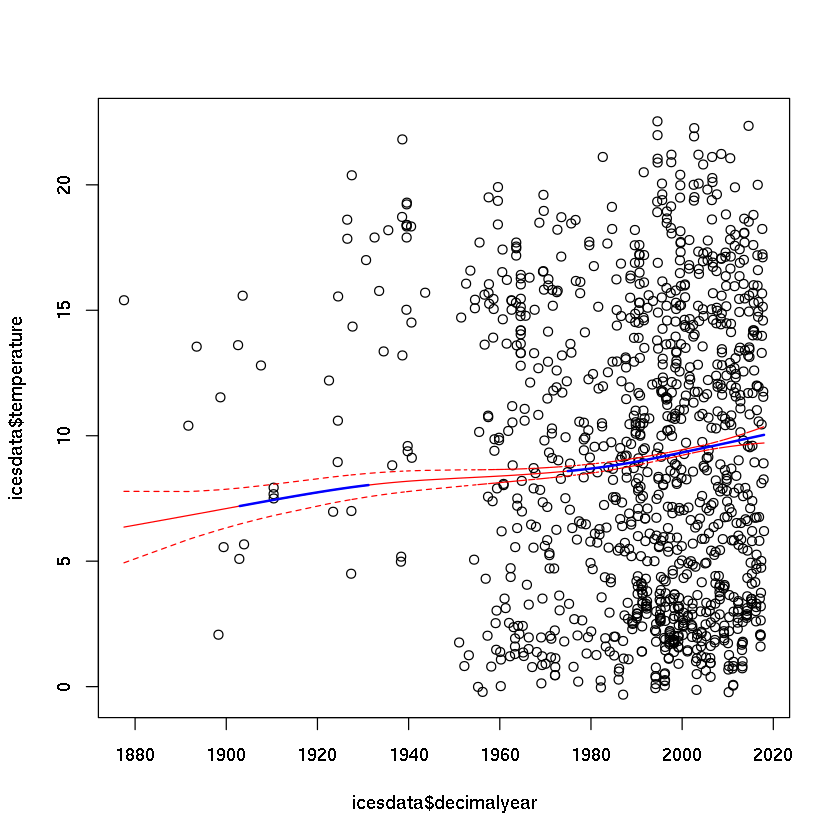

In [8]:


significant_derivative_points = signif_deriv(ices_gamm,term="decimalyear",other_terms = c("season"))
plot(icesdata$decimalyear, icesdata$temperature)
lines(icesdata$decimalyear, pred_temperature, col="red")
lines(icesdata$decimalyear, pred_temperature_min, lty=2, col="red")
lines(icesdata$decimalyear, pred_temperature_max, lty=2, col="red")
lines(significant_derivative_points, lwd=2, col="blue")